# <span style = 'color: Black'> Penalized algorithm for imbalanced classification </span>


In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.plotters as skplt
import os
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_context('notebook')

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## <span style='color:Black'> Start with data exploration  </span>

import the file and start exploring them.

In [5]:
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

print("Train and Test variants shape : ",train_variants_df.shape, test_variants_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [6]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
test_text_df.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [8]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
train_text_df['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

## Distributions

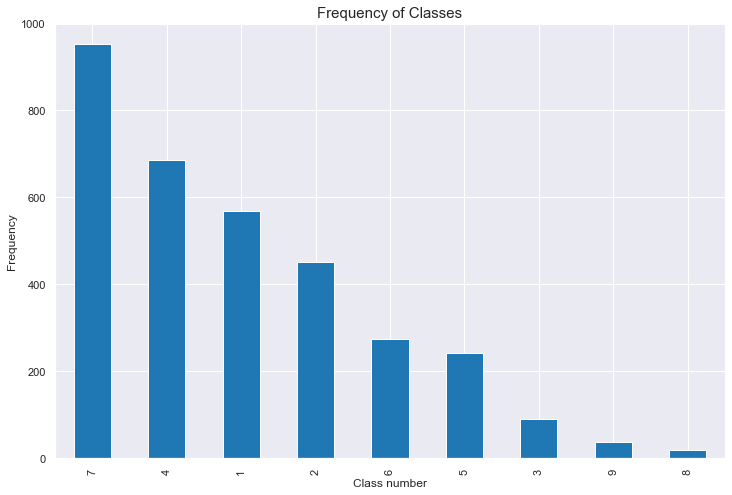

In [10]:
plt.figure(figsize = (12,8))
train_variants_df.Class.value_counts().plot(kind='bar')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class number', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

Class 3,9,8 are minor classes. 

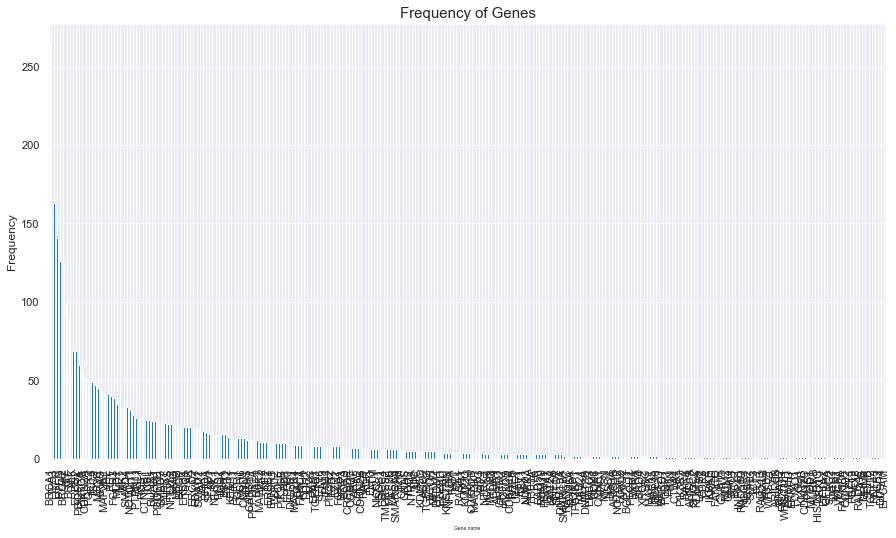

In [13]:
plt.figure(figsize=(15,8))
#sns.countplot(x="Class", data=train_variants_df)
train_variants_df.Gene.value_counts().plot(kind='bar')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Gene name', fontsize=5)
plt.xticks(rotation='vertical')
plt.title("Frequency of Genes", fontsize=15)
plt.show()

Followings are top 10 genes which are prone to mutation.

In [14]:
geneCounts = train_variants_df.Gene.value_counts()
geneCounts.nlargest(10)

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64

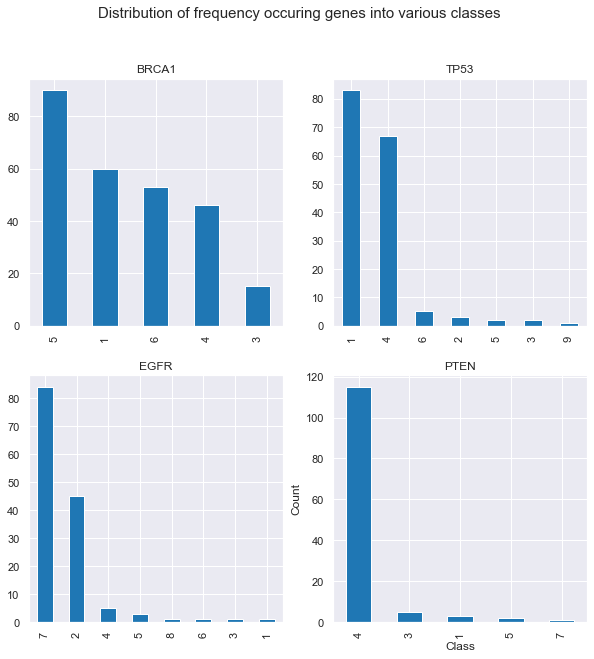

In [16]:
f,axs = plt.subplots(2,2, figsize = (10,10))
f.suptitle("Distribution of frequency occuring genes into various classes", fontsize=15)

train_variants_df.loc[train_variants_df['Gene'] =='BRCA1'].Class.value_counts().plot(kind='bar',ax=axs[0,0])
axs[0,0].set_title('BRCA1')
train_variants_df.loc[train_variants_df['Gene'] =='TP53'].Class.value_counts().plot(kind='bar',ax=axs[0,1])
axs[0,1].set_title('TP53')
train_variants_df.loc[train_variants_df['Gene'] =='EGFR'].Class.value_counts().plot(kind='bar',ax=axs[1,0])
axs[1,0].set_title('EGFR')
train_variants_df.loc[train_variants_df['Gene'] =='PTEN'].Class.value_counts().plot(kind='bar',ax=axs[1,1])
axs[1,1].set_title('PTEN')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [19]:
variationCounts = train_variants_df.Variation.value_counts()
variationCounts.nlargest(10)

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
Q61R                     3
Q61H                     3
E17K                     3
Name: Variation, dtype: int64

In [20]:
# replace X123X variation types with "protein swap" and look at distribution of classes for each variation

mutationTypes = {'Truncating Mutations','Deletion','Amplification','Fusions','Overexpression','ProteinSwap'}

# copy the variation column
train_variants_df['Variation_Alt'] = train_variants_df['Variation']

# replace values
train_variants_df['Variation_Alt'] = np.where(train_variants_df['Variation_Alt'].isin(mutationTypes), train_variants_df['Variation_Alt'], 'ProteinSwap')

In [21]:
train_variants_df['Variation_Alt']

0       Truncating Mutations
1                ProteinSwap
2                ProteinSwap
3                ProteinSwap
4                ProteinSwap
                ...         
3316             ProteinSwap
3317             ProteinSwap
3318                 Fusions
3319             ProteinSwap
3320             ProteinSwap
Name: Variation_Alt, Length: 3321, dtype: object

/Users/Zxp/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


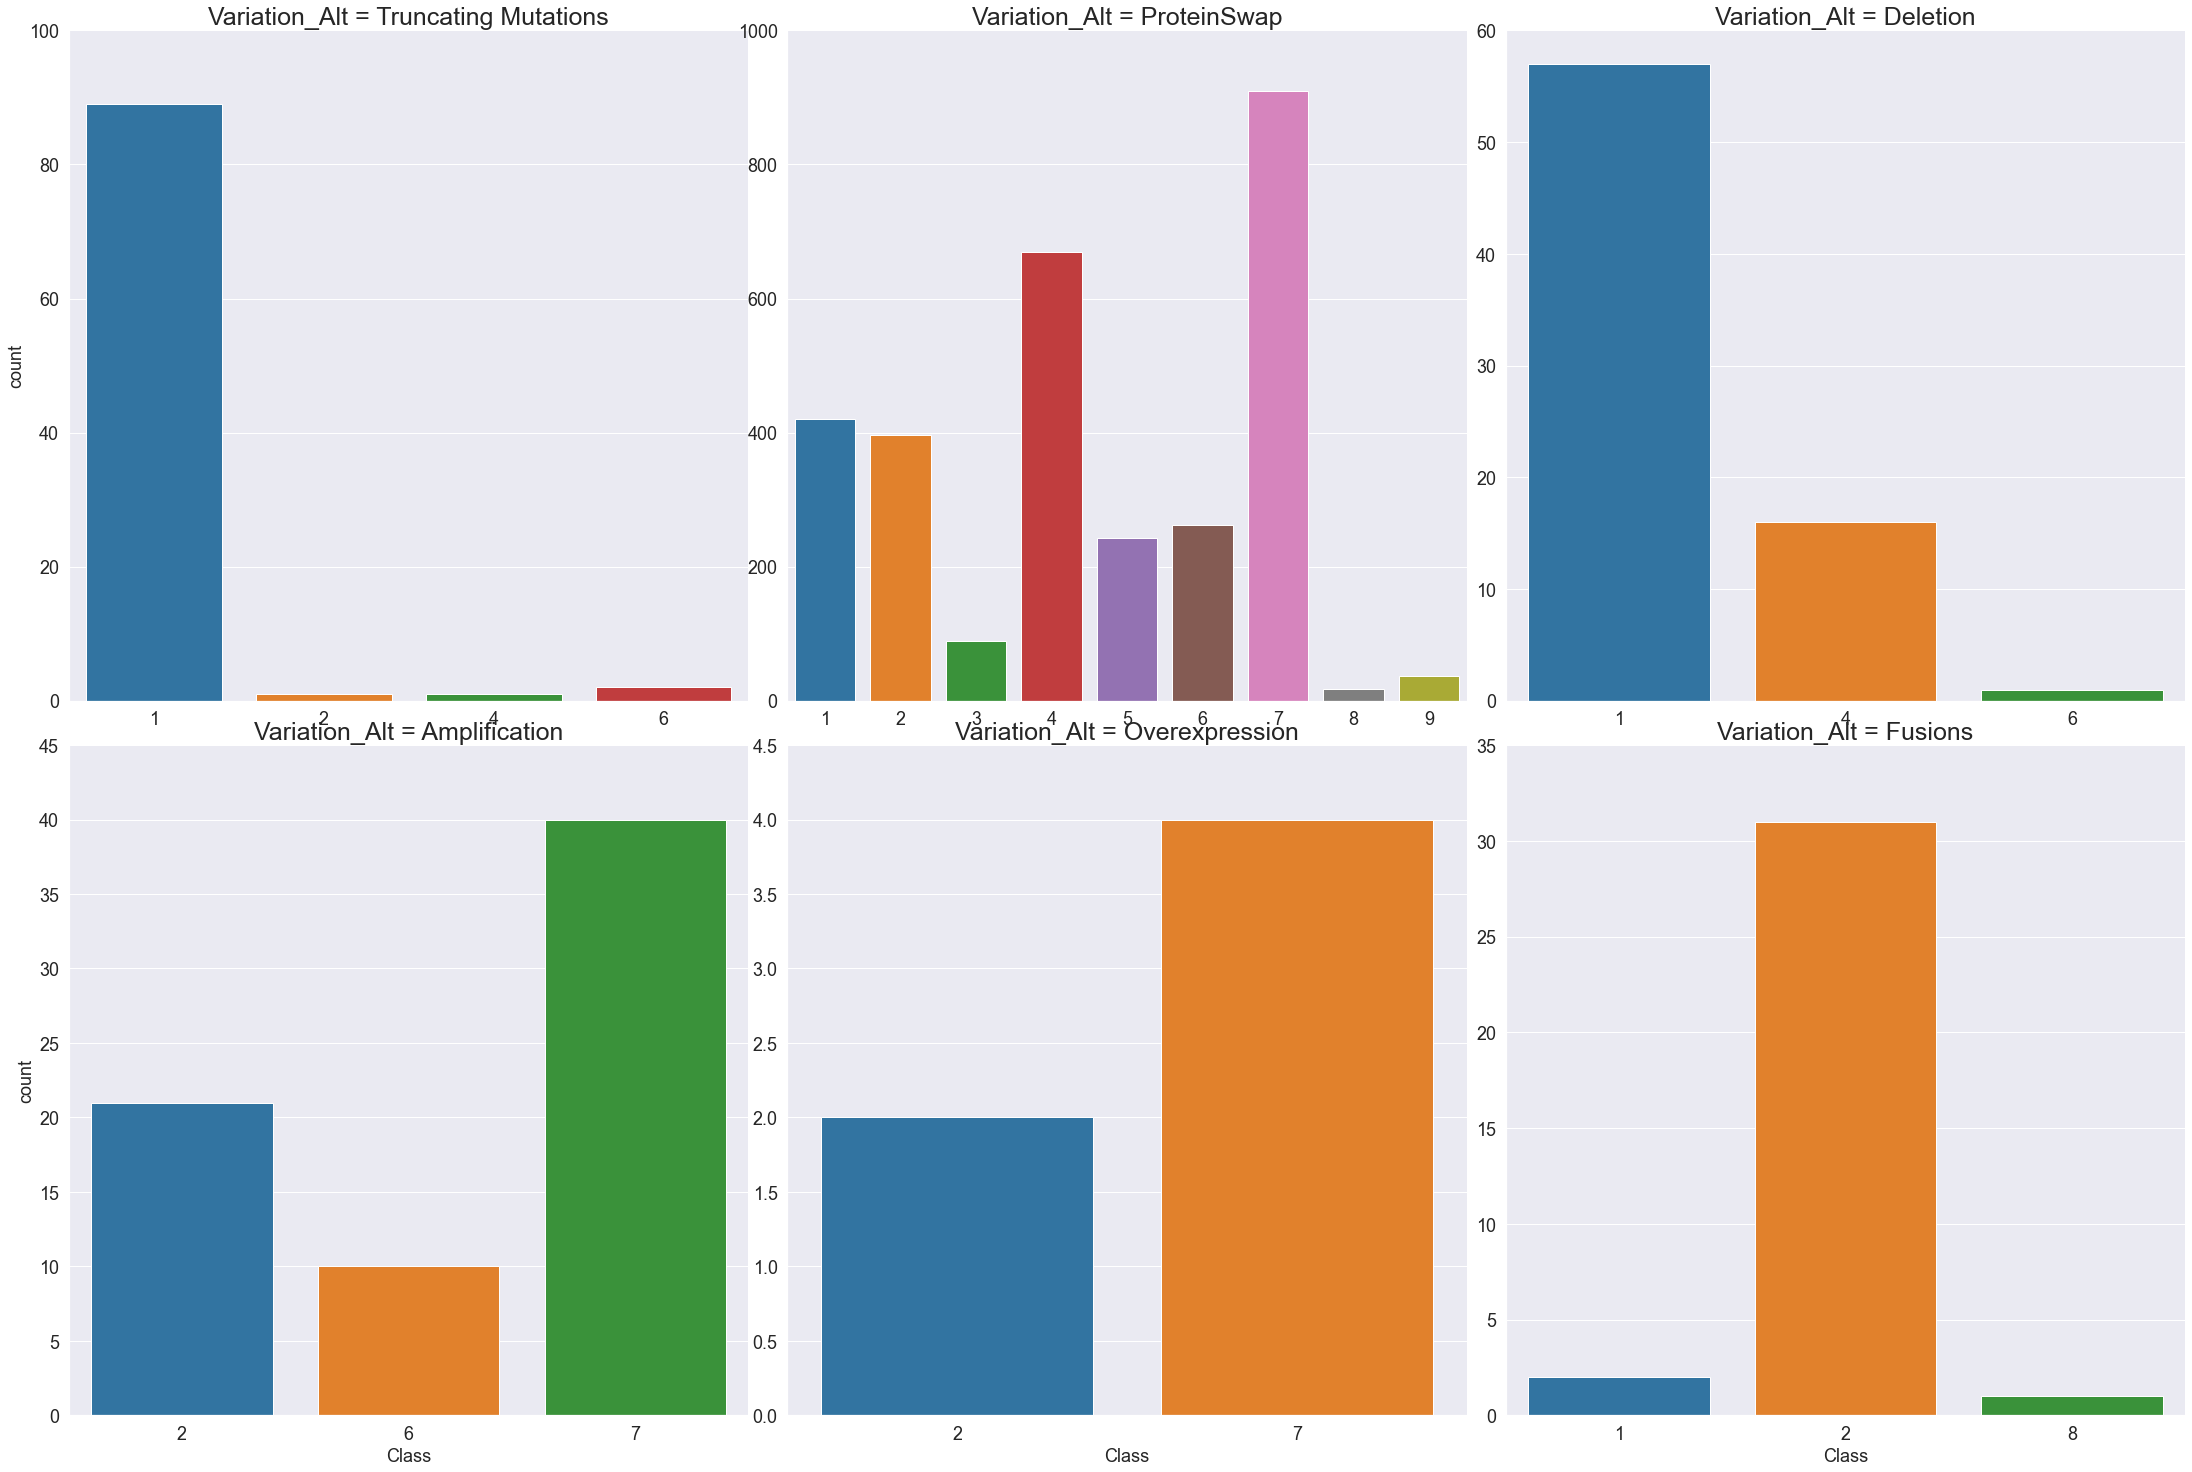

In [22]:
g = sns.catplot(x='Class',data=train_variants_df[['Variation_Alt','Class']],col='Variation_Alt',kind='count',col_wrap=3,
           height = 10,sharey=False,sharex=False)
g.set_yticklabels(size = 18)
g.set_xticklabels(size = 18)
g.set_ylabels(size = 18)
g.set_xlabels(size = 18)
g.set_titles(size = 25)

plt.show()


## Let us look at some text data

In [23]:
# add information about word count and character count
train_text_df["num_words"] = train_text_df["Text"].apply(lambda x: len(str(x).split()) )
train_text_df["num_chars"] = train_text_df["Text"].apply(lambda x: len(str(x)) )

test_text_df["num_words"] = test_text_df["Text"].apply(lambda x: len(str(x).split()) )
test_text_df["num_chars"] = test_text_df["Text"].apply(lambda x: len(str(x)) )

/Users/Zxp/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


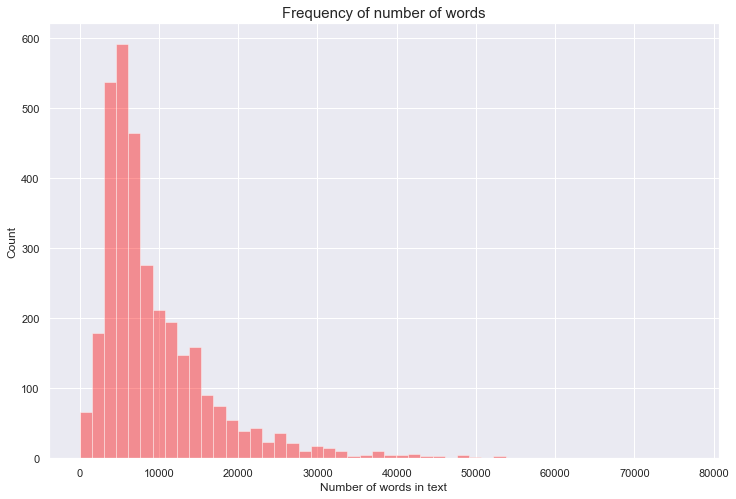

In [24]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

In [25]:
train_text_df.num_words.describe()

count     3321.000000
mean      9551.112014
std       7849.195492
min          1.000000
25%       4733.000000
50%       6871.000000
75%      11996.000000
max      76782.000000
Name: num_words, dtype: float64

In [27]:
# first merge dataframes
train_df = train_variants_df.merge(train_text_df, how='inner', left_on='ID', right_on='ID')
test_df = test_variants_df.merge(test_text_df, how='inner', left_on='ID', right_on='ID')

In [31]:
train_df

,ID,Gene,Variation,Class,Variation_Alt,Text,num_words,num_chars
0,0,FAM58A,Truncating Mutations,1,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39672
1,1,CBL,W802*,2,ProteinSwap,Abstract Background Non-small cell lung canc...,5756,36691
2,2,CBL,Q249E,2,ProteinSwap,Abstract Background Non-small cell lung canc...,5756,36691
3,3,CBL,N454D,3,ProteinSwap,Recent evidence has demonstrated that acquired...,5572,36238
4,4,CBL,L399V,4,ProteinSwap,Oncogenic mutations in the monomeric Casitas B...,6202,41308
...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,ProteinSwap,Introduction Myelodysplastic syndromes (MDS) ...,11028,73895
3317,3317,RUNX1,A122*,1,ProteinSwap,Introduction Myelodysplastic syndromes (MDS) ...,6068,40127
3318,3318,RUNX1,Fusions,1,Fusions,The Runt-related transcription factor 1 gene (...,5122,36200
3319,3319,RUNX1,R80C,4,ProteinSwap,The RUNX1/AML1 gene is the most frequent targe...,4885,32520


In [32]:
train_df = train_df[train_df['Text'].notna()]
test_df = test_df[test_df['Text'].notna()]

In [33]:
train_df

,ID,Gene,Variation,Class,Variation_Alt,Text,num_words,num_chars
0,0,FAM58A,Truncating Mutations,1,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39672
1,1,CBL,W802*,2,ProteinSwap,Abstract Background Non-small cell lung canc...,5756,36691
2,2,CBL,Q249E,2,ProteinSwap,Abstract Background Non-small cell lung canc...,5756,36691
3,3,CBL,N454D,3,ProteinSwap,Recent evidence has demonstrated that acquired...,5572,36238
4,4,CBL,L399V,4,ProteinSwap,Oncogenic mutations in the monomeric Casitas B...,6202,41308
...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,ProteinSwap,Introduction Myelodysplastic syndromes (MDS) ...,11028,73895
3317,3317,RUNX1,A122*,1,ProteinSwap,Introduction Myelodysplastic syndromes (MDS) ...,6068,40127
3318,3318,RUNX1,Fusions,1,Fusions,The Runt-related transcription factor 1 gene (...,5122,36200
3319,3319,RUNX1,R80C,4,ProteinSwap,The RUNX1/AML1 gene is the most frequent targe...,4885,32520


Now let us take a look at the test data.

In [34]:
test_df

,ID,Gene,Variation,Text,num_words,num_chars
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...,7417,49829
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...,4710,31326
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...,11080,75282
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...,8380,53996
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...,11159,76967
...,...,...,...,...,...,...
5663,5663,SLC46A1,R113S,The realization in the late 1970s that RAS har...,11006,76385
5664,5664,FOXC1,L130F,Hemizygous deletions are common molecular abno...,4097,27014
5665,5665,GSS,R267W,All most R267W of has with to SMARTpool invest...,3424,23101
5666,5666,CTSK,G79E,Abstract Blood samples from 125 unrelated fami...,10616,67269


In [3]:
# 1. Transform categorical labels to numerical labels between 0 and len(labels) using labelEncoder
# 2. one hot encode our label
y_train = train_df.Class
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_hot = np_utils.to_categorical(label_encoder.transform(y_train))

# target labels
y_true = [int(x) for x in desired_class.ravel()]
y_true_oh = solution_df_truncated.values


## Prep solution

In [92]:
solution = pd.read_csv('stage1_solution_filtered.csv')

In [93]:
solution.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,1,0,0,0,0,0,0,0,0
1,19,0,1,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0
3,55,0,0,0,1,0,0,0,0,0
4,64,0,0,0,1,0,0,0,0,0


In [94]:
print('The solution has', len(solution), 'entries')
print('The testing set has', len(test_df), 'entries')

The solution has 368 entries
The testing set has 5667 entries


Now we merge the solution set with the testing set.

In [95]:
merge_test_solution = pd.merge(test_df,solution,on='ID')
merge_test_solution.head()

,ID,Gene,Variation,Text,num_words,num_chars,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,TET2,Y1902A,TET proteins oxidize 5-methylcytosine (5mC) on...,7123,46287,1,0,0,0,0,0,0,0,0
1,19,MTOR,D2512H,Genes encoding components of the PI3K-Akt-mTOR...,4283,28722,0,1,0,0,0,0,0,0,0
2,21,KIT,D52N,Myeloproliferative disorders (MPD) constitute ...,2477,15646,0,1,0,0,0,0,0,0,0
3,55,SPOP,F125V,"In the largest E3 ligase subfamily, Cul3 binds...",22727,154677,0,0,0,1,0,0,0,0,0
4,64,KEAP1,C23Y,Keap1 is the substrate recognition module of a...,2854,19253,0,0,0,1,0,0,0,0,0


In [96]:
solution_df_truncated = merge_test_solution.iloc[:,6:6+9]
solution_df_truncated.index = merge_test_solution.ID
solution_df_truncated.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
ID,,,,,,,,,
12,1,0,0,0,0,0,0,0,0
19,0,1,0,0,0,0,0,0,0
21,0,1,0,0,0,0,0,0,0
55,0,0,0,1,0,0,0,0,0
64,0,0,0,1,0,0,0,0,0


In [97]:
test_df_truncated = merge_test_solution.iloc[:,0:6]
test_df_truncated.head()

,ID,Gene,Variation,Text,num_words,num_chars
0,12,TET2,Y1902A,TET proteins oxidize 5-methylcytosine (5mC) on...,7123,46287
1,19,MTOR,D2512H,Genes encoding components of the PI3K-Akt-mTOR...,4283,28722
2,21,KIT,D52N,Myeloproliferative disorders (MPD) constitute ...,2477,15646
3,55,SPOP,F125V,"In the largest E3 ligase subfamily, Cul3 binds...",22727,154677
4,64,KEAP1,C23Y,Keap1 is the substrate recognition module of a...,2854,19253


## Clean the data

In [98]:
import string
import re #regular expressions
from nltk.corpus import stopwords
# note: to use stopwords, first do nltk.download() to download the various corpi in nltk.

# TO DO:
# we should remove the references from the text field!! e.g., if there are references like (1,2) or [5][6]
# use regex expression to clean these up!

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)

def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

In [99]:
allText_train = train_df['Text'].apply(cleanup)
allText_test = test_df_truncated['Text'].apply(cleanup)

In [100]:
# before
train_df['Text'][0][1500:2500]

'molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces re

In [101]:
# after
allText_train[0][1500:2500]

' 20 ago 3 4  cdk10 remains one two cdks without identified cyclin partner knowledge gap largely impeded exploration biological functions cdk10 act positive cell cycle regulator cells 5 6 tumor suppressor others 7 8  cdk10 interacts ets2 vets erythroblastosis virus e26 oncogene homolog 2 transcription factor inhibits transcriptional activity unknown mechanism 9  cdk10 knockdown derepresses ets2 increases expression craf protein kinase activates mapk pathway induces resistance mcf7 cells tamoxifen 6 here deorphanize cdk10 identifying cyclin m product fam58a binding partner mutations gene predict absence truncation cyclin associated star syndrome whose features include toe syndactyly telecanthus anogenital renal malformations heterozygous females 10  however functions cyclin pathogenesis star syndrome remain unknown show recombinant cdk10cyclin heterodimer active protein kinase phosphorylates ets2 vitro cyclin silencing phenocopies cdk10 silencing increasing craf phosphoerk expression le

In [102]:
from gensim.models.doc2vec import TaggedDocument
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [103]:
sentences_train = constructLabeledSentences(allText_train)
sentences_test = constructLabeledSentences(allText_test)
sentences_train[0]

TaggedDocument(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'syndr

## Transform the text into vectors

TFIDF

In [104]:
import nltk
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [105]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

traindf = count_vectorizer.fit_transform(train_df['Text'])

len(count_vectorizer.get_feature_names())

280585

In [106]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_traindf = svd.fit_transform(traindf)

In [107]:
testdf = count_vectorizer.fit_transform(test_df_truncated['Text'])

len(count_vectorizer.get_feature_names())

95390

In [108]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_testdf = svd.fit_transform(testdf)

We'll use test_df_truncated and solution_df_truncated from here on.

## Try penalized models

### 1. The weighted svm model.

In [83]:
from sklearn.svm import SVC
svc_model = SVC(class_weight='balanced', probability=True)

In [91]:
svc_model.fit(truncated_traindf,train_df['Class'].values.ravel())

svc_predict = svc_model.predict(truncated_testdf)# check performance
test_df['Class'].values.ravel()
#print('ROCAUC score:',roc_auc_score(test_df['Class'].values.ravel(),svc_predict))
#print('Accuracy score:',accuracy_score(test_df['Class'].values.ravel(),svc_predict))
#print('F1 score:',f1_score(test_df['Class'].values.ravel(), svc_predict))

KeyError: 'Class'

I still get stuck on implementing this algorithm. 